In [1]:
import sys,csv
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import (make_pipeline, Pipeline)
from sklearn.metrics import make_scorer
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)
from sklearn.utils import resample
import pandas as pd
import itertools
from random import sample

In [2]:
# import dataset
comments = pd.read_csv(r"~\Downloads\Data_ReadyForAnalysis_WithComments&MetaInfo.csv")

#create lsit for test variables
test_variables = ['CONSERVATIVE_DUMMY']

# process comments; write to new dataframe column
comments = comments.dropna(subset = ['commentText'])
select = comments[test_variables+['ID']+['commentText']]  
select = select.drop_duplicates('ID').reset_index(drop = True)
len(select)

3862

## Using annotated dataset to improve our own dataset!

In [6]:
#loading annotated dataset
annotated_df = pd.read_csv(r"C:\Users\shrim\OneDrive - UvA\Project\Project public sphere\annotated_civil_cleaned.csv")

annotated_df.head(5)

,id,comment_text,toxicity,severe_toxicity
0,1083994,He got his money... now he lies in wait till a...,0.373134,0.044776
1,650904,Mad dog will surely put the liberals in mental...,0.605263,0.013158
2,5902188,And Trump continues his lifelong cowardice by ...,0.666667,0.015873
3,7084460,"""while arresting a man for resisting arrest"".\...",0.815789,0.065789
4,5410943,Tucker and Paul are both total bad ass mofo's.,0.550000,0.037500


In [7]:
#classifying (toxicity has to be >.70 to be considered uncivil)
annotated_df['INCIVILITY_DUMMY'] = annotated_df['toxicity'].apply(lambda x: 1 if x > 0.7 else 0)

annotated_df.groupby('INCIVILITY_DUMMY').describe() #check sizes of classes

id                                                 \
                     count          mean           std      min       25%   
INCIVILITY_DUMMY                                                            
0                 998225.0  4.062572e+06  2.529382e+06  59848.0  852998.0   
1                  50350.0  4.090586e+06  2.532718e+06  59856.0  849071.0   

                                                    toxicity            ...  \
                        50%         75%        max     count      mean  ...   
INCIVILITY_DUMMY                                                        ...   
0                 5336429.0  5952202.00  7194640.0  998225.0  0.024136  ...   
1                 5373386.0  5986997.25  7194625.0   50350.0  0.829476  ...   

                                  severe_toxicity                           \
                    75%       max           count      mean       std  min   
INCIVILITY_DUMMY                                                             
0                 0.000  0.698925        998225.0  0.001119  0.007585  0.0   
1                 0.875  1.000000         50350.0  0.040269  0.052308  0.0   

                                                  
                  25%    50%       75%       max  
INCIVILITY_DUMMY                                  
0                 0.0  0.000  0.000000  0.272727  
1                 0.0  0.025  0.059701  1.000000  

[2 rows x 24 columns]

In [8]:
#Downsampling
downsampled = resample(annotated_df[annotated_df['INCIVILITY_DUMMY'] == 0], #resample majority class
             replace=True,
             n_samples=len(annotated_df[annotated_df['INCIVILITY_DUMMY'] == 1]), #resample to the size of the minority class
             random_state=123456789) #random seed set

downsampled_df = pd.concat([downsampled, annotated_df[annotated_df['INCIVILITY_DUMMY'] == 1]]) #concatting downsampled majority class and existing minority class

downsampled_df = downsampled_df.rename(columns={'comment_text':'commentText'}) #renaming column for concat

downsampled_df = downsampled_df.reset_index(drop = True) #resetting index

display(downsampled_df.head(5))

#concat dataset
same_size_annotated = random_sampling(downsampled_df, size = 3862) #random sample from the downsampled annotated df
agg_df = pd.concat([comments, same_size_annotated]) #combined dataset with the random sampled annotated df

agg_df.head(5)

,id,commentText,toxicity,severe_toxicity,INCIVILITY_DUMMY
0,981332,That will start to change with trump in office...,0.0,0.0,0
1,5495116,too bad...............,0.0,0.0,0
2,5312126,"""We don’t connect the attacks on our cities to...",0.0,0.0,0
3,6225676,Young has the right stuff to get the rail on t...,0.0,0.0,0
4,664354,"Once again, the Blue Jays thumb their nose at ...",0.0,0.0,0


,Unnamed: 0,StartDate,RecordedDate,IPAddress,Finished,Coder,ID,Mark_ID,Genre,topiccode,...,date_difference,commentCount_video,replyCount_comment,topic,subscribers,Time_comment_year,Time_video_year,id,toxicity,severe_toxicity
0,0.0,5/30/2021 13:03:17,5/30/2021 13:04:17,62.194.51.29,1.0,6.0,UgyPHwv8G0cDE6-wEgl4AaABAg.8_0ZjJKSJty8_0kXGkAd2U,119.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2017.0,2017.0,NaN,NaN,NaN
1,1.0,10/11/2021 10:34:05,10/11/2021 10:36:46,213.127.109.191,1.0,6.0,Ugx2WXq9UdV8mPPjejJ4AaABAg.8yHCKV0Boe58yYRxEQEF45,282.0,1.0,2.0,...,743.0,1748.0,NaN,economy,3630000.0,2019.0,2019.0,NaN,NaN,NaN
2,2.0,9/9/2021 18:49:48,9/9/2021 18:51:32,213.127.110.0,1.0,6.0,1110578710648890000,372.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,2019.0,NaN,NaN,NaN,NaN
3,3.0,6/6/2021 16:12:46,6/6/2021 16:16:16,213.127.76.145,1.0,6.0,UgwUPFScjJ0MCeaP2F54AaABAg.8lvp3fc9Euf8lvvgsUgEgV,769.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2018.0,2018.0,NaN,NaN,NaN
4,4.0,6/13/2021 13:25:49,6/13/2021 13:27:28,213.127.82.232,1.0,6.0,UgwWKCWtSJdFvjGHvTp4AaABAg.8kUC5dGrQ2H8kUDRihE2f3,1206.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2018.0,2018.0,NaN,NaN,NaN


In [10]:
#Concat annotated dataset with our own dataset
def random_annotated(data):
    '''
    to_be_concat = random_sampling(data, size = size) #random sample from the downsampled annotated df
    agg_df = pd.concat([comments, to_be_concat]) #combined dataset with the random sampled annotated df
    '''
    accuracy = pd.DataFrame(columns = ['Variable', 'Vectorizer', 'Classifier','Parameters', 'F1_score','Recall','Precision','Accuracy','Ratio_test','Ratio_resampled','Manual','Prediction', 'Sample Size'])

    #create train / test split for original dataset
    train_set, test_set = sklearn.model_selection.train_test_split(data, test_size = 0.20, random_state=123456789) 

    train_set = train_set[['INCIVILITY_DUMMY','ID','commentText']]
    test_set = test_set[['INCIVILITY_DUMMY','ID','commentText']]
    
    # #create train / test split for additiona dataset
    # train_set_add, test_set_add = sklearn.model_selection.train_test_split(add_data, test_size = 0.20, random_state=123456789) 
    # train_set_add = train_set_add[['INCIVILITY_DUMMY','commentText']]
    # test_set_add = test_set_add[['INCIVILITY_DUMMY','commentText']]

    #for v in test_variables:
    v = 'INCIVILITY_DUMMY'
    print(v)
    acc,prediction = machine_learning(train_set, test_set, v)

    acc['Variable'] = v
    acc['Ratio_test'] = test_set[v].mean()
    acc['Ratio_prediction'] = prediction.mean()
    accuracy = accuracy.append(acc,ignore_index=True)

    return accuracy


#run ML on original and additional + original datasets
#outcome_annotated = random_annotated(agg_df)
outcome_original = random_annotated(agg_df)

INCIVILITY_DUMMY


In [11]:
outcome_original

,Variable,Vectorizer,Classifier,Parameters,F1_score,Recall,Precision,Accuracy,Ratio_test,Ratio_resampled,...,split0_test_score_std,split1_test_score,split1_test_score_std,split2_test_score,split2_test_score_std,split3_test_score,split3_test_score_std,split4_test_score,split4_test_score_std,Ratio_prediction
0,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,MultinomialNB(),"{'vectorizer__max_df': 0.5, 'vectorizer__min_d...",0.725816,0.780132,0.678571,0.711974,0.488673,0.485839,...,0.007014,0.723164,0.003603,0.729417,0.008740,0.743708,0.002697,0.716113,0.005113,0.49644
1,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,"LogisticRegression(max_iter=1000, n_jobs=-1)","{'classifier__C': 1, 'vectorizer__max_df': 1.0...",0.732516,0.672848,0.803797,0.759871,0.488673,0.485839,...,0.031732,0.672844,0.038004,0.679514,0.043028,0.700409,0.032385,0.667996,0.034336,0.49644
2,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,SVC(class_weight='balanced'),"{'classifier__C': 100, 'vectorizer__max_df': 1...",0.709191,0.684768,0.735420,0.725566,0.488673,0.485839,...,0.309707,0.432116,0.306797,0.437008,0.311034,0.446677,0.316446,0.653959,0.022241,0.49644
3,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,"SVC(class_weight='balanced', kernel='linear')","{'classifier__C': 1, 'vectorizer__max_df': 0.5...",0.719665,0.683444,0.759941,0.739806,0.488673,0.485839,...,0.054826,0.651051,0.051173,0.657217,0.052193,0.668573,0.044073,0.643961,0.049962,0.49644
4,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.TfidfV...,MultinomialNB(),"{'vectorizer__max_df': 1.0, 'vectorizer__min_d...",0.728702,0.736424,0.721141,0.732039,0.488673,0.485839,...,0.007004,0.712315,0.006719,0.732004,0.009874,0.739640,0.009807,0.723295,0.010198,0.49644
5,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.TfidfV...,"LogisticRegression(max_iter=1000, n_jobs=-1)","{'classifier__C': 100, 'vectorizer__max_df': 0...",0.735724,0.733775,0.737683,0.742395,0.488673,0.485839,...,0.259922,0.515102,0.276105,0.523594,0.266485,0.534820,0.276103,0.514945,0.260656,0.49644
6,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.TfidfV...,SVC(class_weight='balanced'),"{'classifier__C': 100, 'vectorizer__max_df': 0...",0.734177,0.691391,0.782609,0.755340,0.488673,0.485839,...,0.333932,0.472356,0.334044,0.475985,0.336623,0.487143,0.344509,0.683976,0.022083,0.49644
7,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.TfidfV...,"SVC(class_weight='balanced', kernel='linear')","{'classifier__C': 100, 'vectorizer__max_df': 1...",0.738502,0.744371,0.732725,0.742395,0.488673,0.485839,...,0.329352,0.466807,0.330470,0.473474,0.335510,0.478225,0.339175,0.681024,0.028402,0.49644


In [148]:
#concat datasets
outcome_annotated['Dataset'] = 'With external dataset'
outcome_original['Dataset'] = 'Original'

outcome_all = pd.concat([outcome_annotated, outcome_original]).reset_index()
outcome_all

,index,Variable,Vectorizer,Classifier,Parameters,F1_score,Recall,Precision,Accuracy,Ratio_test,...,split1_test_score,split1_test_score_std,split2_test_score,split2_test_score_std,split3_test_score,split3_test_score_std,split4_test_score,split4_test_score_std,Ratio_prediction,Dataset
0,0,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,MultinomialNB(),"{'vectorizer__max_df': 0.5, 'vectorizer__min_d...",0.725816,0.780132,0.678571,0.711974,0.488673,...,0.723164,0.003603,0.729417,0.008740,0.743708,0.002697,0.716113,0.005113,0.496440,With external dataset
1,1,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,"LogisticRegression(max_iter=1000, n_jobs=-1)","{'classifier__C': 1, 'vectorizer__max_df': 1.0...",0.732516,0.672848,0.803797,0.759871,0.488673,...,0.672844,0.038004,0.679514,0.043028,0.700409,0.032385,0.667996,0.034336,0.496440,With external dataset
2,2,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,SVC(class_weight='balanced'),"{'classifier__C': 100, 'vectorizer__max_df': 1...",0.709191,0.684768,0.735420,0.725566,0.488673,...,0.432116,0.306797,0.437008,0.311034,0.446677,0.316446,0.653959,0.022241,0.496440,With external dataset
3,3,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,"SVC(class_weight='balanced', kernel='linear')","{'classifier__C': 1, 'vectorizer__max_df': 0.5...",0.719665,0.683444,0.759941,0.739806,0.488673,...,0.651051,0.051173,0.657217,0.052193,0.668573,0.044073,0.643961,0.049962,0.496440,With external dataset
4,4,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.TfidfV...,MultinomialNB(),"{'vectorizer__max_df': 1.0, 'vectorizer__min_d...",0.728702,0.736424,0.721141,0.732039,0.488673,...,0.712315,0.006719,0.732004,0.009874,0.739640,0.009807,0.723295,0.010198,0.496440,With external dataset
5,5,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.TfidfV...,"LogisticRegression(max_iter=1000, n_jobs=-1)","{'classifier__C': 100, 'vectorizer__max_df': 0...",0.735724,0.733775,0.737683,0.742395,0.488673,...,0.515102,0.276105,0.523594,0.266485,0.534820,0.276103,0.514945,0.260656,0.496440,With external dataset
6,6,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.TfidfV...,SVC(class_weight='balanced'),"{'classifier__C': 100, 'vectorizer__max_df': 0...",0.734177,0.691391,0.782609,0.755340,0.488673,...,0.472356,0.334044,0.475985,0.336623,0.487143,0.344509,0.683976,0.022083,0.496440,With external dataset
7,7,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.TfidfV...,"SVC(class_weight='balanced', kernel='linear')","{'classifier__C': 100, 'vectorizer__max_df': 1...",0.738502,0.744371,0.732725,0.742395,0.488673,...,0.466807,0.330470,0.473474,0.335510,0.478225,0.339175,0.681024,0.028402,0.496440,With external dataset
8,0,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,MultinomialNB(),"{'vectorizer__max_df': 0.5, 'vectorizer__min_d...",0.720510,0.892105,0.604278,0.659767,0.491591,...,0.672021,0.011196,0.669541,0.023146,0.643097,0.035737,0.657641,0.020903,0.725744,Original
9,1,INCIVILITY_DUMMY,<class 'sklearn.feature_extraction.text.CountV...,"LogisticRegression(max_iter=1000, n_jobs=-1)","{'classifier__C': 1, 'vectorizer__max_df': 0.5...",0.629310,0.576316,0.693038,0.666235,0.491591,...,0.593665,0.035132,0.577115,0.062145,0.587511,0.040462,0.615831,0.033798,0.725744,Original


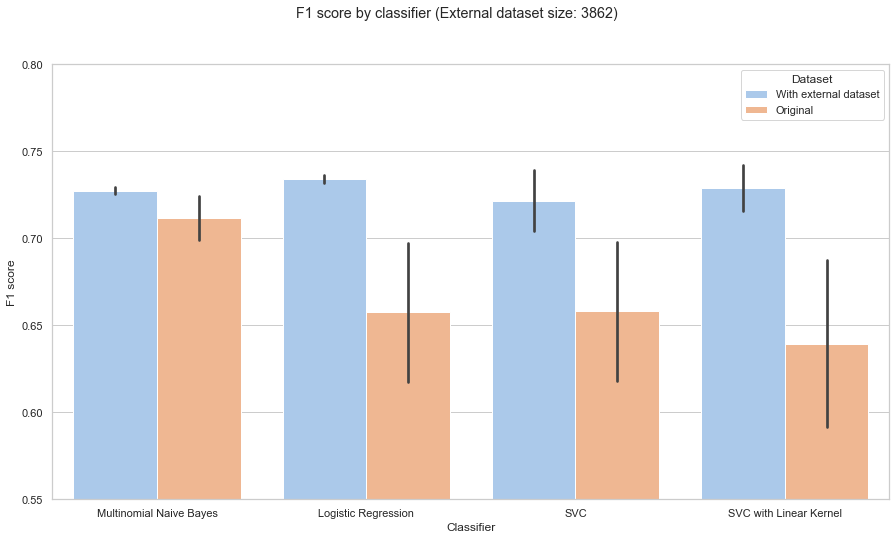

In [160]:
#F1 score
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(15,8))
plt.suptitle('F1 score by classifier (External dataset size: 3862)')
sns.barplot(x=outcome_all['Classifier'].astype(str), y=outcome_all['F1_score'], hue=outcome_all['Dataset'], errorbar='sd').set(xticklabels=['Multinomial Naive Bayes','Logistic Regression','SVC','SVC with Linear Kernel'])
plt.ylabel("F1 score")
plt.ylim(0.55, 0.8)
plt.show()

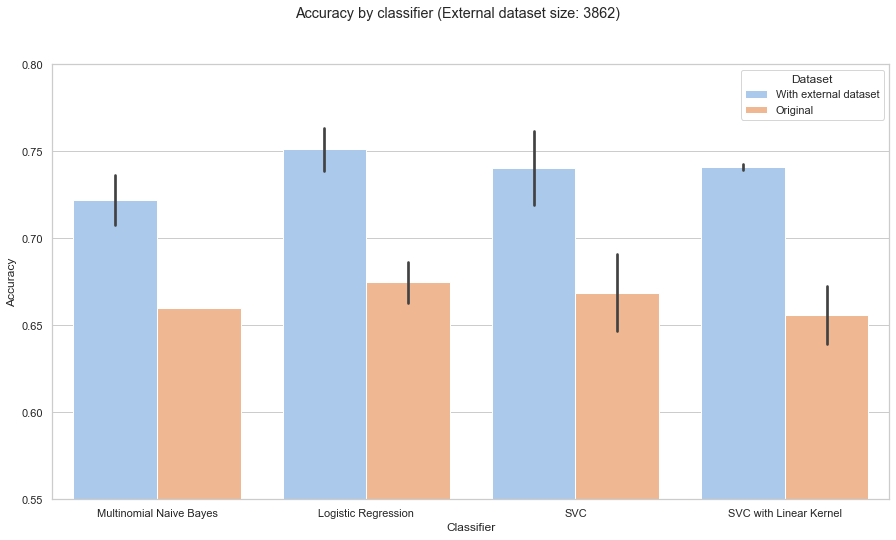

In [161]:
#F1 score
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(15,8))
plt.suptitle('Accuracy by classifier (External dataset size: 3862)')
sns.barplot(x=outcome_all['Classifier'].astype(str), y=outcome_all['Accuracy'], hue=outcome_all['Dataset'], errorbar='sd').set(xticklabels=['Multinomial Naive Bayes','Logistic Regression','SVC','SVC with Linear Kernel'])
plt.ylabel("Accuracy")
plt.ylim(0.55, 0.8)
plt.show()